# Kinegeometric 1D distance and 2D velocity estimation 

The kinegeometric distance posterior is given by a 3D probability density function in distance and velocity. Previously, the summary statistics have been calculated by sampling from the 3D distribution (Bailer-Jones 2023). It has been shown that the 3D sampling can be replaced by marginal 1D sampling in distance and 2D sampling in velocity, which requires less computation time. 

This notebook tests and compares the sampling of the 1D sampling of the marginal distance posterior and 2D sampling of the marginal velocity posterior to the 3D sampling. 

In [1]:
# Sample the kinegeometric distance posterior - an outline
# CBJ Feb. 2024
# Work in units of kpc, km/s, mas, and mas/yr.

In [2]:
import numpy as np
from scipy.special import gamma, factorial, loggamma
from scipy.stats import multivariate_normal as mvn

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import emcee # https://emcee.readthedocs.io/en/stable/
# Other possible samplers:
# https://pymcmcstat.readthedocs.io/en/latest/
# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/MetropolisHastings
# https://python4mpia.github.io/fitting_data/Metropolis-Hastings.html - old

import rpy2
from rpy2.robjects.packages import importr, data
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects import r

numpy2ri.activate() #activate conversion from R-code to numpy arrays
from astroquery.gaia import Gaia
import math
from zero_point import zpt # need to install gaiadr3-zeropoint
zpt.load_tables()

from metropolis import metrop
from functions import mode_post3 
from scipy import integrate



GACS is operational after the datacentre migration but DataLink is not yet fully operational


R[write to console]: data.table 1.13.6 using 12 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Lade nötiges Paket: bit

R[write to console]: 
Attache Paket: ‘bit’


R[write to console]: The following object is masked from ‘package:data.table’:

    setattr


R[write to console]: The following object is masked from ‘package:base’:

    xor


R[write to console]: Attaching package bit64

R[write to console]: package:bit64 (c) 2011-2017 Jens Oehlschlaegel

R[write to console]: creators: integer64 runif64 seq :

R[write to console]: coercion: as.integer64 as.vector as.logical as.integer as.double as.character as.bitstring

R[write to console]: logical operator: ! & | xor != == < <= >= >

R[write to console]: arithmetic operator: + - * / %/% %% ^

R[write to console]: math: sign abs sqrt log log2 log10

R[write to console]: math: floor ceiling trunc round

R[write to console]: querying: is.integer64 is.vector [is.atomic} [length] format print str

R[write t

In [3]:
# Constants
kfac = 4.740471 # vel[km/s] = kfac * r[kpc] * propm[mas/yr]
# seed
seed = 123
np.random.seed(seed)

In [4]:
# Define functions

# Return the mean (meanTau) [1/(km/s)] and covariance (CovTau) [1/(km/s)^2]
# of the velocity prior 
# Sourced from R-file: call_velocity_prior.R
r_source2 = robjects.r['source']
r_source2('./Rfiles/call_velocity_prior.R')
kinegeo_prior_stats = robjects.globalenv['eval.prior.healpix']

def velpriorparams(dist, healpix):
    # Return the mean (meanTau) [1/(km/s)] and covariance (CovTau) [1/(km/s)^2]
    # of the velocity prior 
    
    vramean_tau, vrasd_tau, vdecmean_tau, vdecsd_tau, cor_tau = kinegeo_prior_stats(p=healpix,r=dist*1e3)  # output is in km/s, takes input in pc
    
    meanTau = np.array([vramean_tau,vdecmean_tau])
    CovTau = np.array([[vrasd_tau**2 ,vrasd_tau * vdecsd_tau *cor_tau], 
                       [vrasd_tau*vdecsd_tau*cor_tau,vdecsd_tau**2]])
    
    return meanTau , CovTau

def logdistpriordensity(dist, alpha,beta,rlen):
    # Return log (base 10) of the unnormalized distance prior [1/kpc]
    
    # convert rlen from pc to kpc 
    rlen = rlen*1e-3

    #dist = np.where(dist > 0,dist,0)
    #prior = 1/(gamma((beta+1)/alpha)) * alpha/(rlen**(beta+1)) * dist**beta * np.exp(-((dist/rlen)**alpha))
    #logPrior = np.log10(prior)
    logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
    
    return 0.4342945*logPrior

def logparallaxlikelihood(dist, parallax, parallaxVar):
    # Return log (base 10) of the (normalized) likelhood of the parallax at this distance.
    # parallaxVar is the relevant element of the Cov3 matrix.
    # This is a simple 1D Gaussian density.
    return 0.4342945* mvn.logpdf(parallax,mean=1/dist,cov=parallaxVar)
    
    
def loggeopostdensity(dist, parallax, parallaxVar, alpha,beta,rlen):
    # Return the log (base 10) of the unnormalized density of the geometric distance 
    # posterior [1/kpc]  
    # logparallaxlikelihood + logdistpriordensity
    
    result = logparallaxlikelihood(dist=dist, parallax=parallax, parallaxVar=parallaxVar)\
    + logdistpriordensity(dist=dist,alpha=alpha,beta=beta,rlen=rlen)

    #if dist > 0:     
    #    result =  logparallaxlikelihood(dist=dist, parallax=parallax, parallaxVar=parallaxVar)\
    #    + logdistpriordensity(dist=dist,alpha=alpha,beta=beta,rlen=rlen)
    #else: 
    #    result = -np.inf

    return result

    
def logQfunc(dist, parallax, propm, Cov3, Cov2, kfac,healpix, meanTau, CovTau):
    """
    Implements Equation 8d
    In principle we only need the inverse of a covariance matrix to compute
    an unnormalized Gaussian, in which case we could just pass invCov2 and would
    not need Cov2. But scipy.stats.multivariate_normal doesn't seem to give this option.
    We could pass invCov2 to save inverting it for use in m_v and Cov_v, but it's only
    so just write it out explicitly.

    Parameters
    ----------
    dist:      distance [kpc] scalar
    parallax:  parallax [mas] scalar
    promp:     proper motion [mas/yr] 2-element vector
    Cov3:      full data astrometric covariance matrix [various] 3x3 matrix
    Cov2:      partial data covariance matrix [(mas/yr)^2] 2x2 matrix
    CovTau:    velocity prior covariance matrix [(km/s)^2] 2x2 matrix
    kfac:      constant

    Returns
    -------
    Log (base 10) density of Q(r,parallax,promp)
    """
    
    # Compute the inverse of Cov2 (equation 4b)
    # Compute X_mu (equation 4a)
    # Call velpriorparams() to get meanTau and CovTau
    # Invert CovTau
    # Compute logdensity of Q using scipy.stats.multivariate_normal.logpdf
    # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html
    # - don't forget to multiply by kfac*dist to get Q.
     
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_w = Cov3[0,0]
    
    X_mu = Sigma_mu_w * Sigma_w_w**(-1) * (parallax - (1/dist))
    
    
    logN = 0.4342945* mvn.logpdf(x=meanTau,mean=kfac*dist*(propm-X_mu),cov=kfac**2 * dist**2 * Cov2 + CovTau)
    
    return np.log10(kfac*dist) + logN
    
def logkinegeopostdensity(dist, parallax, parallaxVar ,propm, Cov3, Cov2, healpix, alpha,beta,rlen, kfac):
    # Return the log (base 10) of the (unnormalized) density of the kinegeometric 
    # distance posterior [1/kpc]  
    # logQfunc + loggeopostdensit
    
    meanTau, CovTau = velpriorparams(dist=dist, healpix=healpix)
    
    result = logQfunc(dist=dist, parallax=parallax, propm=propm, Cov3=Cov3, Cov2=Cov2, kfac=kfac,healpix=healpix, meanTau=meanTau, CovTau=CovTau)\
        + loggeopostdensity(dist=dist, parallax=parallax, parallaxVar=parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
    
    #if dist > 0:     
    #    result = logQfunc(dist=dist, parallax=parallax, propm=propm, Cov3=Cov3, Cov2=Cov2, kfac=kfac,healpix=healpix, meanTau=meanTau, CovTau=CovTau)\
    #    + loggeopostdensity(dist=dist, parallax=parallax, parallaxVar=parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
    #
    #else: 
    #    result = -np.inf

    return result

## 1. Test 1D kinegeometric distance estimation for a single source 

First, we test the sampling of the marginal 1D sampling of a single source. 

In [5]:
# Define data: parallax, prompm, Cov3 (equation 2)
# The parallax should be zero-point corrected.
# Compute (once) Cov2 (equation 4b)

source_id = 3490289749867760896 #3490291841517005824

job = Gaia.launch_job("select top 10 "
                                        "source_id, parallax, parallax_error,\
                                        phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour,\
                                        ecl_lat, astrometric_params_solved,bp_rp,pmra,pmra_error,\
                                        pmdec, pmdec_error,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr "
                                        "from gaiadr3.gaia_source "
                                        "where source_id={}".format(int(source_id)))
r = job.get_results()

w = float(r['parallax'])
sd_w = float(r['parallax_error'])   

mu_ra = float(r['pmra'])
mu_dec = float(r['pmdec'])
sd_mu_ra = float(r['pmra_error'])
sd_mu_dec = float(r['pmdec_error'])
corr_w_mu_ra = float(r['parallax_pmra_corr'])
corr_w_mu_dec = float(r['parallax_pmdec_corr'])
corr_mu_ra_dec = float(r['pmra_pmdec_corr'])

phot_g_mean_mag = float(r['phot_g_mean_mag'])
nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'])
pseudocolour = float(r['pseudocolour'])
ecl_lat = float(r['ecl_lat'])
astrometric_params_solved = float(r['astrometric_params_solved'])


#source_id = int(r['source_id'])
healpix = math.floor(source_id / (2**(35)*4**(12-5)) )

# zeropoint correction
if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
    if  phot_g_mean_mag == np.nan:
        wzp = -0.017                    
    else:
         wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
else: 
    wzp = 0

parallax = w - wzp

parallaxVar = sd_w**2

propm = np.array([mu_ra,mu_dec])

Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                 [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                 [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])


Sigma_w_w = Cov3[0,0]
Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
Sigma_w_mu = np.transpose(Sigma_mu_w) #np.array([Cov3[0,1],Cov3[0,2]])
Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                       [Cov3[2,1],Cov3[2,2]]])



Cov2 = Sigma_mu_mu - np.outer(Sigma_mu_w,np.dot(Sigma_w_w**(-1),Sigma_w_mu))


print('\033[1m' + f'Data for Gaia DR3 {source_id}: ' + '\033[0m')
print('')
print('HEALpixel level 5:',healpix)
print('parallax [mas]',w)
print('parallax error [mas]',sd_w)
print('Zeropoint [mas]', wzp)
print('Zeropointcorrected parallax w[mas]',parallax)
print('proper motion ra [mas/yr]:',mu_ra)
print('proper motion dec [mas/yr]:',mu_dec)
print('proper motion ra error [mas/yr]:',sd_mu_ra)
print('proper motion dec error [mas/yr]:',sd_mu_dec)
print('parallax - proper motion ra correlation: ',corr_w_mu_ra)
print('parallax - proper motion dec correlation: ',corr_w_mu_dec)
print('proper motion ra-dec correlation: ',corr_mu_ra_dec)



Data for Gaia DR3 3490289749867760896: 

HEALpixel level 5: 6200
parallax [mas] 0.9456172699741828
parallax error [mas] 0.9242838621139526
Zeropoint [mas] -0.012552
Zeropointcorrected parallax w[mas] 0.9581692699741828
proper motion ra [mas/yr]: -2.5227925377013465
proper motion dec [mas/yr]: -0.4972104607767501
proper motion ra error [mas/yr]: 0.970378577709198
proper motion dec error [mas/yr]: 0.6900551319122314
parallax - proper motion ra correlation:  -0.1622094213962555
parallax - proper motion dec correlation:  -0.14073950052261353
proper motion ra-dec correlation:  -0.0007732694502919912


/tmp/ipykernel_10378/3513501485.py:29: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r['pseudocolour'])


### 1.1 using own metropolis algorithm

The sampler that is used is a simple metropolis algorithm which can be found in metropolis.py.  Nsamp gives the final number of samples and Nburnin the number of burnins. The mode of EDSD-posterior is used to initialize the metropolis algorithm. Only execute next cell if you wand to use metropolis.py.

In [6]:
# Sample logkinegeopostdensity 
# Use an MCMC package. You may need a wrapper function to logkinegeopostdensity so that
# it's argument and return(s) are in the right order/format for the MCMC function.
# Try your Metropolis first.
# Later: maybe try emcee. Probably 4-8 walkers is enough. We'll need to experiment to determine
# how much burnin and how many samples, but I expect around 20-50 and 50-100 is enough
# (depending on the number of walkers). Try initializing the walkers close to the
# median of the geometric posterior, with a standard deviation equal to the (robust)
# standard deviation of that that posterior.

# For testing purposes, you should also directly compute a few different posteriors
# on a dense grid , so as to compare the "true" distribution.

# used mode of EDSD-posterior to initialize metrop algorithm, transform to kpc

Nsamp= 1000
Nburnin= 500

rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)

alpha = float(rows_prior_summary[healpix][6])
beta = float(rows_prior_summary[healpix][7])
rlen = float(rows_prior_summary[healpix][5])
    
rlen_EDSD = float(rows_prior_summary[healpix][10])
rInit = float(mode_post3(w=1e-3*parallax,wsd=1e-3*sd_w,rlen = rlen_EDSD,retall = False))*1e-3 
rStep = 0.75*rInit*min(1/3, abs(sd_w/parallax))

#geometric samples
samp_geo = metrop(func=loggeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,seed=seed,parallax=parallax, parallaxVar = parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
rSamp_geo = samp_geo[:,1]

#kinegeometric samples
samp_kinegeo = metrop(func=logkinegeopostdensity ,thetaInit= rInit, Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,seed=seed,parallax=parallax, parallaxVar = parallaxVar,propm=propm, Cov3=Cov3, Cov2=Cov2, healpix=healpix,alpha=alpha,beta=beta,rlen=rlen, kfac=kfac)
rSamp_kinegeo = samp_kinegeo[:,1]



/tmp/ipykernel_10378/857391877.py:31: RuntimeWarning: invalid value encountered in log
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
/tmp/ipykernel_10378/857391877.py:31: RuntimeWarning: invalid value encountered in power
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
/tmp/ipykernel_10378/857391877.py:99: RuntimeWarning: invalid value encountered in log10
  return np.log10(kfac*dist) + logN


### 1.2 Alternatively: sample using emcee

Alternatively, I tried to sample using the emcee package, which has the option to use multiple walkers. If using emcee, the function that is sampled needs to return -inf if it is out of range, so for $r \leq 1$. Only execute the next cell if you want to use emcee.  

In [7]:
#Nsamp= 1000
#Nburnin= 500
#ndim = 1
#nwalkers = 5
#
#rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)
#
#alpha = float(rows_prior_summary[healpix][6])
#beta = float(rows_prior_summary[healpix][7])
#rlen = float(rows_prior_summary[healpix][5])
#    
#rlen_EDSD = float(rows_prior_summary[healpix][10])
#rInit = float(mode_post3(w=1e-3*parallax,wsd=1e-3*sd_w,rlen = rlen_EDSD,retall = False))*1e-3 
#
## geometric samples
#p0_geo = np.random.uniform(low=0.75*rInit, high=1.25*rInit, size=(nwalkers,1)) # initialisatzion: random value between 0.75 and 1.25 * mode of geometric posterior
#sampler_geo = emcee.EnsembleSampler(nwalkers, ndim, loggeopostdensity, args=[parallax, parallaxVar, alpha,beta,rlen])
#
#
#state_geo = sampler_geo.run_mcmc(p0_geo, Nburnin)
#sampler_geo.reset()
#
#sampler_geo.run_mcmc(state_geo, Nsamp)
#
#samp_geo = sampler_geo.get_chain(flat=True)
##plt.hist(samp_geo, 50, color="k", histtype="step")
#rSamp_geo = samp_geo.flatten()
#
#
## kinegeometric samples
#
##p0 = np.random.normal(loc=np.median(rSamp_geo), scale=np.std(rSamp_geo),size=(nwalkers,1))
#sampler_kinegeo = emcee.EnsembleSampler(nwalkers, ndim, logkinegeopostdensity, args=[parallax, parallaxVar ,propm, Cov3, Cov2, healpix,alpha,beta,rlen, kfac])
#
#
#state_kinegeo = sampler_kinegeo.run_mcmc(p0_geo, Nburnin)
#sampler_kinegeo.reset()
#
#sampler_kinegeo.run_mcmc(state_kinegeo, Nsamp)
#
#samp_kinegeo = sampler_kinegeo.get_chain(flat=True)
##plt.hist(samp, 50, color="k", histtype="step")
#
#rSamp_kinegeo = samp_kinegeo.flatten()
#
#
#print(
#    "Mean acceptance fraction Geo: {0:.3f}".format(
#        np.mean(sampler_geo.acceptance_fraction)
#    )
#)
#
#print(
#    "Mean acceptance fraction Kinegeo: {0:.3f}".format(
#        np.mean(sampler_kinegeo.acceptance_fraction)
#    )
#)
#
#sampler_kinegeo.reset()
#sampler_geo.reset()

Next plot the results. 

Distance estimation:

MCMC initialization [pc]: 0.9680553726796431
MCMC stepsize [pc]: 0.24201384316991076
MCMC number of burn-in samples: 500
MCMC number of retained iterations: 1000

Kinegeometric distance:

estimated distance [pc] (quantile 0.5): 3.9682144227318212
lower distance limit [pc] (quantile 0.159): 1.0651380842559592
upper distance limit [pc] (quantile 0.841): 5.271393745705079

Geometric distance:

estimated distance [pc] (quantile 0.5): 2.4916754622660457
lower distance limit [pc] (quantile 0.159): 0.85901150073775
upper distance limit [pc] (quantile 0.841): 4.106249358485205



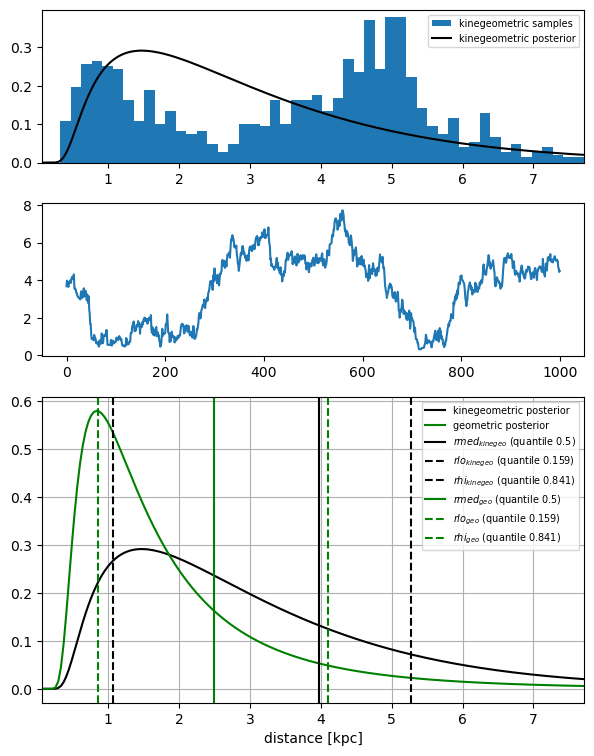

In [8]:
# Plots

fig,ax = plt.subplots(3,1,figsize=(7,9), gridspec_kw={'height_ratios': [1,1,2]})

# distance range for plotting
rplotlo = 0.2*min(rSamp_kinegeo)
rplothi = 1*max(rSamp_kinegeo)

r_plot = np.linspace(rplotlo,rplothi,200)

# plot histogram of samples
ax[0].hist(rSamp_kinegeo,bins=50,density=True,label='kinegeometric samples')
ax[0].set_xlim(rplotlo,rplothi)

#plot chains
ax[1].plot(np.arange(0,len(rSamp_kinegeo),1),rSamp_kinegeo)

# plot kinegeo + geo posterior              
logKinegeo_plot=[]
logGeo_plot = []

for i in r_plot: 
    logKinegeo_plot.append(logkinegeopostdensity(dist=i, parallax=parallax, parallaxVar=parallaxVar ,\
                                                 propm=propm, Cov3=Cov3, Cov2=Cov2, healpix=healpix,alpha=alpha,beta=beta,rlen=rlen, kfac=kfac))
    logGeo_plot.append(loggeopostdensity(dist=i, parallax=parallax, parallaxVar=parallaxVar, alpha=alpha,beta=beta,rlen=rlen))
    
kinegeo_plot = 10**(np.array(logKinegeo_plot))         
kinegeo_norm = integrate.trapezoid(kinegeo_plot,r_plot)

geo_plot = 10**(np.array(logGeo_plot))
geo_norm = integrate.trapezoid(geo_plot,r_plot)


ax[2].plot(r_plot,kinegeo_plot/kinegeo_norm, label='kinegeometric posterior',color='k')
ax[0].plot(r_plot,kinegeo_plot/kinegeo_norm, label='kinegeometric posterior',color='k')

ax[2].plot(r_plot,geo_plot/geo_norm,label='geometric posterior',color='green')

ax[2].set_xlim(rplotlo,rplothi)
ax[2].set_xlabel('distance [kpc]')
ax[2].grid()

# get quantiles: 

probs = np.array([0.5,0.1586553,0.8413447])
rQuant_kinegeo = np.quantile(rSamp_kinegeo,probs)
rest_kinegeo = rQuant_kinegeo[0]
rlo_kinegeo = rQuant_kinegeo[1]
rhi_kinegeo = rQuant_kinegeo[2]

rQuant_geo = np.quantile(rSamp_geo,probs)
rest_geo = rQuant_geo[0]
rlo_geo = rQuant_geo[1]
rhi_geo = rQuant_geo[2]


ax[2].axvline(rest_kinegeo,label ='$rmed_{kinegeo}$ (quantile 0.5)',color='k')
ax[2].axvline(rlo_kinegeo,linestyle='--',label ='$rlo_{kinegeo}$ (quantile 0.159)',color='k')
ax[2].axvline(rhi_kinegeo,linestyle='--',label ='$rhi_{kinegeo}$ (quantile 0.841)',color='k')

ax[2].axvline(rest_geo,label ='$rmed_{geo}$ (quantile 0.5)',color='green')
ax[2].axvline(rlo_geo,linestyle='--',label ='$rlo_{geo}$ (quantile 0.159)',color='green')
ax[2].axvline(rhi_geo,linestyle='--',label ='$rhi_{geo}$ (quantile 0.841)',color='green')

ax[2].legend(fontsize=7)
ax[0].legend(fontsize=7)



print('\033[1m' + 'Distance estimation:' + '\033[0m')
print('')
print('MCMC initialization [pc]:', rInit)
print('MCMC stepsize [pc]:',rStep)
print('MCMC number of burn-in samples:',Nburnin)
print('MCMC number of retained iterations:',Nsamp)
print('')
print('Kinegeometric distance:')
print('')
print('estimated distance [pc] (quantile 0.5):',rest_kinegeo)
print('lower distance limit [pc] (quantile 0.159):', rlo_kinegeo)
print('upper distance limit [pc] (quantile 0.841):', rhi_kinegeo)
print('')
print('Geometric distance:')
print('')
print('estimated distance [pc] (quantile 0.5):',rest_geo)
print('lower distance limit [pc] (quantile 0.159):', rlo_geo)
print('upper distance limit [pc] (quantile 0.841):', rhi_geo)
print('')


## 2. Test 2D kinegeometric velocity estimation for a single source 

The samples from above are now used to sample the velocities for the same source. For each distance sample, n samples are drawn for the velocity and the mean is calculated from those.

In [9]:
# Other functions only required for velocity posterior

def logvelpriordensity(vel, dist, healpix):
    # Return log (base 10) density of the velocity prior [1/(km/s)^2] using 
    # scipy.stats.multivariate_normal.logpdf
    # Call velpriorparams(dist, healpix)
    
    meanTau, CovTau = velpriorparams(dist=dist, healpix=healpix)
    N = mvn.pdf(x=vel,mean=meanTau,cov=CovTau)
    
    return np.log10(N)

def velpostparams(dist, parallax, Cov2, Cov3, propm, healpix, kfac): 
    # Return the mean (meanVel) [km/s] and covariance (CovVel) [km/s^2]
    # of the velocity posterior 
    
    meanTau, CovTau = velpriorparams(dist=dist, healpix=healpix)
    invCovTau = np.linalg.inv(CovTau)
    
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_w = Cov3[0,0]
    
    X_mu = Sigma_mu_w * Sigma_w_w**(-1) * (parallax - (1/dist))
    mean2 = propm + X_mu
    
    A = np.linalg.inv(kfac**2 * dist**2 * Cov2)
    
    CovVel = np.linalg.inv(A + invCovTau)

    meanVel = np.matmul(CovVel , np.matmul(A*kfac*dist, propm - X_mu )+np.matmul(invCovTau,meanTau))
    
    
    return meanVel, CovVel 


In [10]:
# sample n velocities and take the mean for each kinegeo distance sample

n = 10
Nsamp = len(rSamp_kinegeo)

totVelsamp = [] #mean of velocity samples for all distances
totMeanVel = [] #mean of velocity posterior for all distances 

for i in range(len(rSamp_kinegeo)): 
    
    meanVel, CovVel = velpostparams(dist=rSamp_kinegeo[i], parallax=parallax, Cov2=Cov2, Cov3=Cov3, propm=propm, healpix=healpix, kfac=kfac)
    velsamp = np.random.multivariate_normal(mean = meanVel, cov = CovVel,size = n)
    velsamp_mean = np.mean(velsamp, axis=0)
    totVelsamp.append(velsamp_mean)
    totMeanVel.append(meanVel)
    
    
totVelsamp = np.array(totVelsamp)
totMeanVel = np.array(totMeanVel)

#get results: mean and quantiles of v_ra and v_dec + correlation between array of v_ra and v_dec samples
    
raVel = np.quantile(totVelsamp[:,0], probs)
decVel = np.quantile(totVelsamp[:,1], probs)
corrVel = np.corrcoef(totVelsamp[:,0], totVelsamp[:,1])

# Expectation value of velocity
    
E_v = 1/Nsamp * sum(totMeanVel)

#covariance between each velocity and distance

r_mean = 1/Nsamp * sum(rSamp_kinegeo)

Cov_rv_ra = 1/Nsamp * sum((rSamp_kinegeo-r_mean)*(totMeanVel[:,0]-E_v[0]))
Cov_rv_dec = 1/Nsamp * sum((rSamp_kinegeo-r_mean)*(totMeanVel[:,1]-E_v[1]))



In [11]:
#print summary statistics: 
print('\033[1m' + 'Velocity estimation:' + '\033[0m')
print('')
print('Number of velocity samples drawn for reach of the MCMC distance samples: ',n)
print('')
print('Estimated velocities:')
print('')
print('velocity in ra:')
print('estimated velocity [km/s] (quantile 0.5): ', raVel[0])
print('lower velocity limit [km/s] (quantile 0.159): ',raVel[1])
print('upper velocity limit [km/s](quantile 0.841): ',raVel[2])
print('')
print('velocity in dec:')
print('estimated velocity [km/s] (quantile 0.5): ', decVel[0])
print('lower velocity limit [km/s] (quantile 0.159): ',decVel[1])
print('upper velocity limit [km/s](quantile 0.841): ',decVel[2])
print('')
print('Correlation between v_ra and v_dec: ', corrVel[1,0])
print('')
print('Covariance between each velocity and distance:' )
print('Cov_rv_ra [kpc km/s]: ',Cov_rv_ra )
print('Cov_rv_dec [kpc km/s]: ',Cov_rv_dec )

Velocity estimation:

Number of velocity samples drawn for reach of the MCMC distance samples:  10

Estimated velocities:

velocity in ra:
estimated velocity [km/s] (quantile 0.5):  -45.93730565107745
lower velocity limit [km/s] (quantile 0.159):  -62.74516143726338
upper velocity limit [km/s](quantile 0.841):  -13.105973474305618

velocity in dec:
estimated velocity [km/s] (quantile 0.5):  -5.7142176378541105
lower velocity limit [km/s] (quantile 0.159):  -11.208417255737782
upper velocity limit [km/s](quantile 0.841):  -1.685129145106734

Correlation between v_ra and v_dec:  0.5371734062393092

Covariance between each velocity and distance:
Cov_rv_ra [kpc km/s]:  -38.33030145989412
Cov_rv_dec [kpc km/s]:  -4.9853866653670496


## 3. Compare multiple sources to 3D sampling

### 3.1 Compare distance estimation results of 1000 stars of hp 6200

Next, for an array of stars, the summary statistics (quantiles) of the distance are calculated using the 1D sampling method and compared to the results when using the 3D sampling method. For this, the metropolis.py sampler is used. 

At first, the desired 3D comparison data is read in. Then an array containing source_ids as well as an array containing the data is created. In the array containing the data, there is also an entry containing the source_id. The source_id however has to be used from the array containing the source_id, because in the data array, it has been rounded when reading it in. 





In [12]:
# Read in comparison data 

# array containing source_ids 
id_distvel_6200 = np.genfromtxt('./2024-04-16/distvel_files/distvel_6200.csv', delimiter=',', skip_header=1,  dtype='int64', usecols=0) 

# array containig all 3D data (dont use source_id from this, because its rounded, instead use array above)
data_distvel_6200 =  np.genfromtxt('./2024-04-16/distvel_files/distvel_6200.csv', delimiter=',', skip_header=1,  dtype='float64') 

# alternative file: './results_est_distvel/distvel_files/distvel_6200_new.csv': contains (less) stars with available samples 

# remove all rows containing nan: 
comp_data = data_distvel_6200[~np.isnan(data_distvel_6200).any(axis=1), :]#[:100]
comp_source_ids = id_distvel_6200[~np.isnan(data_distvel_6200).any(axis=1)]#[:100]

#extract data from Gaia 

source_ids_string = ", ".join(map(str, comp_source_ids))
job = Gaia.launch_job("select "
                                            "source_id, parallax, parallax_error,phot_g_mean_mag,\
                                            nu_eff_used_in_astrometry, pseudocolour,\
                                            ecl_lat, astrometric_params_solved,bp_rp,\
                                            pmra,pmra_error,pmdec, pmdec_error,parallax_pmra_corr,\
                                            parallax_pmdec_corr,pmra_pmdec_corr "
                                            "from gaiadr3.gaia_source "
                                            "where source_id in ({})".format(source_ids_string))
r = job.get_results()



Now, the 1D marginal dstance estimation is performed for each source. 
The kinegeometric samples are finally saved to the csv file "rSamples_kinegeo.csv" in the folder "results" and the geometric samples are saved to the file "rSamples_geo.csv" in the same folder. 

In [13]:
# sample posterior for each source 

# Uses metropolis algorithm from metropolis.py
# Nsamp: final number of samples
# Nburnin: Number of burnins

rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)

rSamples_kinegeo = []
rSamples_geo = []

Nsamp= 1000
Nburnin= 500


for i in range(len(comp_source_ids[:])): 

    w = float(r['parallax'][i])
    sd_w = float(r['parallax_error'][i])   
    
    mu_ra = float(r['pmra'][i])
    mu_dec = float(r['pmdec'][i])
    sd_mu_ra = float(r['pmra_error'][i])
    sd_mu_dec = float(r['pmdec_error'][i])
    corr_w_mu_ra = float(r['parallax_pmra_corr'][i])
    corr_w_mu_dec = float(r['parallax_pmdec_corr'][i])
    corr_mu_ra_dec = float(r['pmra_pmdec_corr'][i])
    
    phot_g_mean_mag = float(r['phot_g_mean_mag'][i])
    nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'][i])
    pseudocolour = float(r['pseudocolour'][i])
    ecl_lat = float(r['ecl_lat'][i])
    astrometric_params_solved = float(r['astrometric_params_solved'][i])
    
    
    source_id = int(r['SOURCE_ID'][i])
    print('#',i,'   ',source_id)
    healpix = math.floor(source_id / (2**(35)*4**(12-5)) )
    
    # zeropoint correction
    if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
        if  phot_g_mean_mag == np.nan:
            wzp = -0.017                    
        else:
             wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
    else: 
        wzp = 0
    
    parallax = w - wzp
    parallaxVar = sd_w**2
    propm = np.array([mu_ra,mu_dec])
    
    Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                     [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                     [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])
    
    
    Sigma_w_w = Cov3[0,0]
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_mu = np.transpose(Sigma_mu_w) #np.array([Cov3[0,1],Cov3[0,2]])
    Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                           [Cov3[2,1],Cov3[2,2]]])
    
    
    
    Cov2 = Sigma_mu_mu - np.outer(Sigma_mu_w, Sigma_w_w**(-1)*Sigma_w_mu)
    
    
    alpha = float(rows_prior_summary[healpix][6])
    beta = float(rows_prior_summary[healpix][7])
    rlen = float(rows_prior_summary[healpix][5])
    rlen_EDSD = float(rows_prior_summary[healpix][10])
    
    rInit = float(mode_post3(w=1e-3*parallax,wsd=1e-3*sd_w,rlen = rlen_EDSD,retall = False))*1e-3 
    rStep = 0.75*rInit*min(1/3, abs(sd_w/parallax))
    
    #kinegeometric samples
    samp_kinegeo = metrop(func=logkinegeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,parallax=parallax, seed=seed,parallaxVar = parallaxVar,propm=propm, Cov3=Cov3, Cov2=Cov2, healpix=healpix, alpha=alpha,beta=beta,rlen=rlen,kfac=kfac)
    rSamp_kinegeo = samp_kinegeo[:,1]
    rSamples_kinegeo.append(rSamp_kinegeo)
    
    #geometric samples
    samp_geo = metrop(func=loggeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,seed=seed, parallax=parallax, parallaxVar = parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
    rSamp_geo = samp_geo[:,1]
    rSamples_geo.append(rSamp_geo)
    
# save to csv file; all samples for one source_id are in one row, same order as input 

np.savetxt('./results/rSamples_kinegeo.csv', rSamples_kinegeo, delimiter=",")
np.savetxt('./results/rSamples_geo.csv', rSamples_geo, delimiter=",")

/tmp/ipykernel_5316/1433854312.py:31: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r['pseudocolour'][i])


# 0     3490289711213205632


/tmp/ipykernel_5316/857391877.py:99: RuntimeWarning: invalid value encountered in log10
  return np.log10(kfac*dist) + logN
/tmp/ipykernel_5316/857391877.py:31: RuntimeWarning: invalid value encountered in log
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
/tmp/ipykernel_5316/857391877.py:31: RuntimeWarning: invalid value encountered in power
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha


# 1     3490289715508854016
# 2     3490289749867760896


/tmp/ipykernel_5316/1433854312.py:30: UserWarning: Warning: converting a masked element to nan.
  nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'][i])


# 3     3490289814292421888
# 4     3490289818586888576


/Home/no233/linux/.local/lib/python3.9/site-packages/zero_point/zpt.py:233: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  warnings.warn(


# 5     3490289852947807744
# 6     3490289883011898496
# 7     3490289887307937920
# 8     3490289921667284352
# 9     3490289956027023232
# 10     3490290054810590720
# 11     3490290089170329984
# 12     3490290089170330240
# 13     3490290089170331008
# 14     3490290093465144320
# 15     3490290093465144448
# 16     3490290123530068992
# 17     3490290157889807232
# 18     3490290157889807616
# 19     3490290157889809024
# 20     3490290162184620928
# 21     3490290226609285888
# 22     3490290230904930560
# 23     3490290299624407424
# 24     3490290398407978752
# 25     3490290471422342144
# 26     3490290471423100160
# 27     3490290505782080128
# 28     3490290574502314752
# 29     3490290604566409472
# 30     3490290608862052864
# 31     3490290638926148096
# 32     3490290638926148864
# 33     3490290711941269248
# 34     3490290746301007488
# 35     3490290776365105024
# 36     3490290776365105792
# 37     3490290776365106048
# 38     3490290849380220544
# 39     3490290879

Next, the distance samples are loaded and the summary statistics (quantiles) are computed.

In [13]:
# compute distance statistics for each source

# load samples 

rSamples_kinegeo = np.loadtxt('./results/rSamples_kinegeo.csv', delimiter=',')
rSamples_geo = np.loadtxt('./results/rSamples_geo.csv', delimiter=',')

#get quantiles: 

probs = np.array([0.5,0.1586553, 0.8413447])


rMedKinegeo_all = []
rLoKinegeo_all = []
rHiKinegeo_all = []

rMedGeo_all = []
rLoGeo_all = []
rHiGeo_all = []

for i in range(len(rSamples_kinegeo)):     
    
    rQuantKinegeo = np.quantile(rSamples_kinegeo[i],probs)
    
    rMedKinegeo = rQuantKinegeo[0]
    rLoKinegeo = rQuantKinegeo[1]
    rHiKinegeo= rQuantKinegeo[2]
    
    rMedKinegeo_all.append(rMedKinegeo)
    rLoKinegeo_all.append(rLoKinegeo)
    rHiKinegeo_all.append(rHiKinegeo)
    
    rQuantGeo = np.quantile(rSamples_geo[i],probs)
    
    rMedGeo = rQuantGeo[0]
    rLoGeo = rQuantGeo[1]
    rHiGeo= rQuantGeo[2]
    
    rMedGeo_all.append(rMedGeo)
    rLoGeo_all.append(rLoGeo)
    rHiGeo_all.append(rHiGeo)
    
    

After that, the 2D velocity samples are drawn for each distance sample and summary statistics are calculated. 

In [15]:
# Compute velocity statistics for each source

n = 1

raVel_all = []
decVel_all = []
corrVel_all = []
Cov_rv_ra_all = []
Cov_rv_dec_all = []

totVelsamp_all = []

# loop over all sources: 

for j in range(len(rSamples_kinegeo)): 

    # sample n velocities and take the mean for each kinegeo distance sample

    Nsamp = len(rSamples_kinegeo[j])
    
    totVelsamp = [] #mean of velocity samples for all distances
    totMeanVel = [] #mean of velocity posterior for all distances 
    
    # data from gaia 
    
    w = float(r['parallax'][j])
    sd_w = float(r['parallax_error'][j])   
    
    mu_ra = float(r['pmra'][j])
    mu_dec = float(r['pmdec'][j])
    sd_mu_ra = float(r['pmra_error'][j])
    sd_mu_dec = float(r['pmdec_error'][j])
    corr_w_mu_ra = float(r['parallax_pmra_corr'][j])
    corr_w_mu_dec = float(r['parallax_pmdec_corr'][j])
    corr_mu_ra_dec = float(r['pmra_pmdec_corr'][j])
    
    phot_g_mean_mag = float(r['phot_g_mean_mag'][j])
    nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'][j])
    pseudocolour = float(r['pseudocolour'][j])
    ecl_lat = float(r['ecl_lat'][j])
    astrometric_params_solved = float(r['astrometric_params_solved'][j])
    
    
    source_id = int(r['SOURCE_ID'][j])
    print('#',j,'    ',source_id)
    healpix = math.floor(source_id / (2**(35)*4**(12-5)) )
    
    # zeropoint correction
    if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
        if  phot_g_mean_mag == np.nan:
            wzp = -0.017                    
        else:
            wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
    else: 
        wzp = 0
    
    parallax = w - wzp
    parallaxVar = sd_w**2
    propm = np.array([mu_ra,mu_dec])
    
    Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                    [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                    [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])
    
    
    Sigma_w_w = Cov3[0,0]
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_mu = np.transpose(Sigma_mu_w) #np.array([Cov3[0,1],Cov3[0,2]])
    Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                        [Cov3[2,1],Cov3[2,2]]])
    
    
    
    Cov2 = Sigma_mu_mu - np.outer(Sigma_mu_w, Sigma_w_w**(-1)*Sigma_w_mu)
    
    
    # loop over all samples of a source:
    for i in range(len(rSamples_kinegeo[j])): 
        
        meanVel, CovVel = velpostparams(dist=rSamples_kinegeo[j][i], parallax=parallax, Cov2=Cov2, Cov3=Cov3, propm=propm, healpix=healpix, kfac=kfac)
        velsamp = np.random.multivariate_normal(mean = meanVel, cov = CovVel,size = n)
        velsamp_mean = np.mean(velsamp, axis=0)
        totVelsamp.append(velsamp_mean)
        totMeanVel.append(meanVel)
        
    
    totVelsamp_all.append(totVelsamp)
    totVelsamp = np.array(totVelsamp)
    totMeanVel = np.array(totMeanVel)
    
    #get results: mean and quantiles of v_ra and v_dec + correlation between array of v_ra and v_dec samples
        
    raVel = np.quantile(totVelsamp[:,0], probs)
    decVel = np.quantile(totVelsamp[:,1], probs)
    corrVel = np.corrcoef(totVelsamp[:,0], totVelsamp[:,1])
    
    # Expectation value of velocity
        
    E_v = 1/Nsamp * sum(totMeanVel)
    
    #covariance between each velocity and distance
    
    r_mean = 1/Nsamp * sum(rSamples_kinegeo[j])
    
    Cov_rv_ra = 1/Nsamp * sum((rSamples_kinegeo[j]-r_mean)*(totMeanVel[:,0]-E_v[0]))
    Cov_rv_dec = 1/Nsamp * sum((rSamples_kinegeo[j]-r_mean)*(totMeanVel[:,1]-E_v[1]))
    
    raVel_all.append(raVel)
    decVel_all.append(decVel)
    corrVel_all.append(corrVel)
    Cov_rv_ra_all.append(Cov_rv_ra)
    Cov_rv_dec_all.append(Cov_rv_dec)



/tmp/ipykernel_5316/2746620985.py:39: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r['pseudocolour'][j])


3490289711213205632
3490289715508854016
3490289749867760896


/tmp/ipykernel_5316/2746620985.py:38: UserWarning: Warning: converting a masked element to nan.
  nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'][j])


3490289814292421888
3490289818586888576
3490289852947807744
3490289883011898496
3490289887307937920
3490289921667284352
3490289956027023232
3490290054810590720
3490290089170329984
3490290089170330240
3490290089170331008
3490290093465144320
3490290093465144448
3490290123530068992
3490290157889807232
3490290157889807616
3490290157889809024
3490290162184620928
3490290226609285888
3490290230904930560
3490290299624407424
3490290398407978752
3490290471422342144
3490290471423100160
3490290505782080128
3490290574502314752
3490290604566409472
3490290608862052864
3490290638926148096
3490290638926148864
3490290711941269248
3490290746301007488
3490290776365105024
3490290776365105792
3490290776365106048
3490290849380220544
3490290879444313856
3490290879444314496
3490290913804053376
3490290948163792000
3490290952459436032
3490290986819174528
3490291051243010304
3490291055538651776
3490291119962484736
3490291188681962368
3490291188681962496
3490291192977982080
3490291223041700992
3490291223041701632


Finally, all summary statistics of velocity and distance are saved to the "results.csv" file in the "results" folder. 

In [17]:
# save summary statistics to csv file

import csv

header = ['source_id',\
          'rMedGeo', 'rLoGeo', 'rHiGeo',\
          'rMedKinogeo', 'rLoKinogeo', 'rHiKinogeo',\
         'vRaMedKinogeo', 'vRaLoKinogeo', 'vRaHiKinogeo',\
         'vDecMedKinogeo', 'vDecLoKinogeo', 'vDecHiKinogeo',\
         'rvraCorrKinogeo', 'rvdecCorrKinogeo', 'vravdecCorrKinogeo']

with open('./results/results.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(len(comp_source_ids[:])): 
        writer.writerow([comp_source_ids[i],\
                         rMedGeo_all[i], rLoGeo_all[i], rHiGeo_all[i],\
                         rMedKinegeo_all[i], rLoKinegeo_all[i], rHiKinegeo_all[i],\
                         raVel_all[i][0],raVel_all[i][1],raVel_all[i][2],\
                         decVel_all[i][0],decVel_all[i][1],decVel_all[i][2],\
                         Cov_rv_ra_all[i],Cov_rv_dec_all[i],corrVel_all[i][0,1]])
                         

Save plots of the chains and histograms to results.pdf

In [15]:
# plot samples

p = PdfPages('./results/results.pdf')

for i in range(len(comp_source_ids)):
    
    # Create a new figure for each iteration
    
    fig,ax = plt.subplots(2,2,figsize=(7,7), gridspec_kw={'height_ratios': [1,2]})
    
    ax[0,0].plot(np.arange(0,len(rSamples_kinegeo[i]),1),rSamples_kinegeo[i])
    ax[1,0].hist(rSamples_kinegeo[i],bins=20,density=True)
    plt.suptitle(f"Gaia DR3 {comp_source_ids[i]}")
    ax[1,0].set_title(f"1D sampling")
    plt.tight_layout()
    
    ax[1,0].axvline(rMedKinegeo_all[i],color='black') 
    ax[1,0].axvline(rLoKinegeo_all[i],linestyle='--',color = 'black') 
    ax[1,0].axvline(rHiKinegeo_all[i],linestyle='--',color = 'black') 
    
    
    # load compasion samples 
   
    j = np.where(comp_source_ids == comp_source_ids[i])[0][0]
   
    comp_samples_kinegeo = np.loadtxt(f'./2024-04-16/posterior_samples/kinogeosamples_6200_{comp_source_ids[i]}.csv', delimiter=',',skiprows=1)
    comp_rSamp_kinegeo = comp_samples_kinegeo[:,0]
    
    ax[0,1].plot(np.arange(0,len(comp_rSamp_kinegeo),1),comp_rSamp_kinegeo/1e3)
    ax[1,1].hist(comp_rSamp_kinegeo/1e3,bins=20,density=True)
    ax[1,1].set_title(f"3D sampling")
    
    ax[1,1].axvline(comp_data[j][4]/1e3 ,color='black') 
    ax[1,1].axvline(comp_data[j][5]/1e3, linestyle='--',color = 'black') 
    ax[1,1].axvline(comp_data[j][6]/1e3,linestyle='--',color = 'black') 
    
    
    ax[1,0].sharex(ax[1,1])
    p.savefig()
    plt.close()
p.close()

Comparison plots of the results of the 3D (_comp) vs 1D (_res) kinegeometric distance sampling for all sources: 

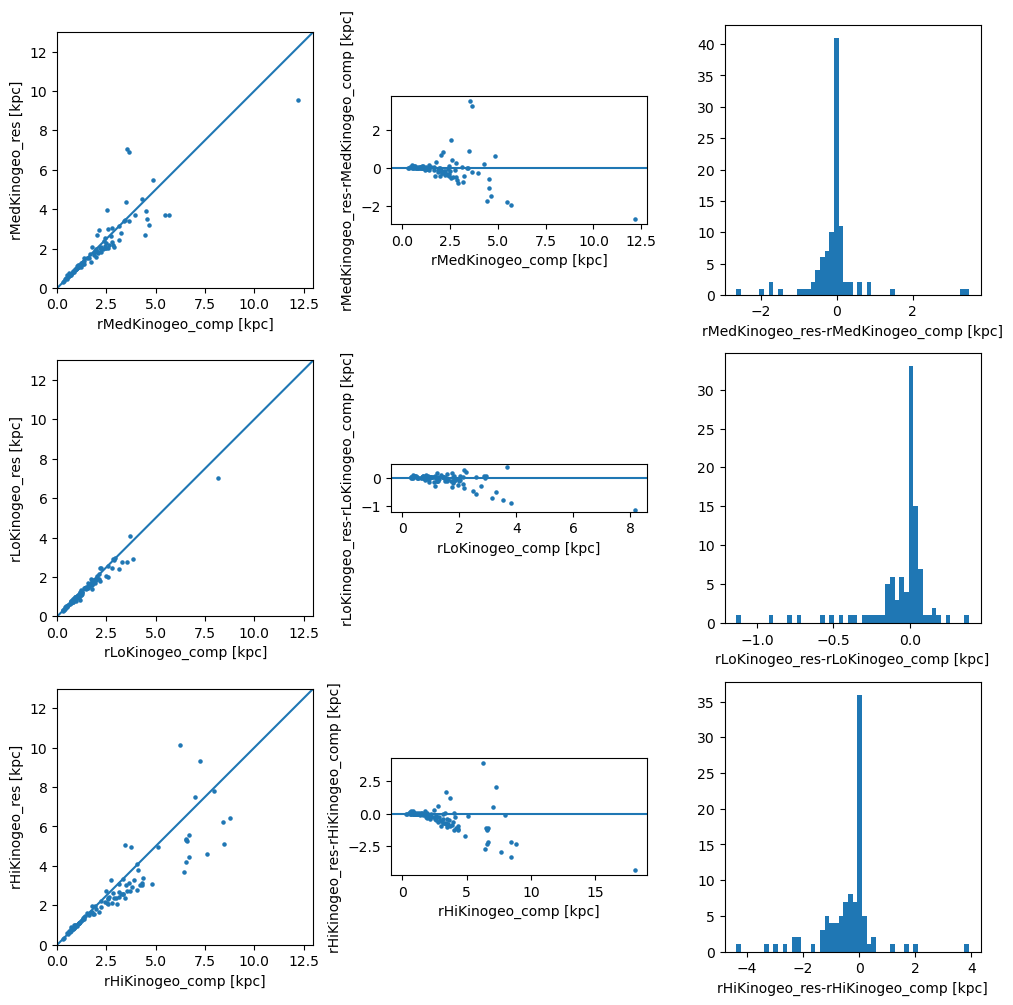

In [18]:
# plot comparison plots of Kinegeo distance estimation
#  _res indicates the results from this notebook, _comp indicates comparison data 

# read in csv with own results

results = np.loadtxt('./results/results.csv', delimiter=',',skiprows=1)

# plots 

fig,ax = plt.subplots(3,3,figsize=(10,10))

# rMedKinogeo

ax[0,0].scatter(comp_data[:,4]/1e3, results[:,4],s=5)
ax[0,0].set_ylabel('rMedKinogeo_res [kpc]')
ax[0,0].set_xlabel('rMedKinogeo_comp [kpc]')
ax[0,0].set_aspect('equal')
ax[0,0].set_ylim(0,13)
ax[0,0].set_xlim(0,13)
ax[0,0].axline((0, 0), slope=1)


ax[0,1].scatter(comp_data[:,4]/1e3, results[:,4]-comp_data[:,4]/1e3,s=5)
ax[0,1].set_ylabel('rMedKinogeo_res-rMedKinogeo_comp [kpc]')
ax[0,1].set_xlabel('rMedKinogeo_comp [kpc]')
ax[0,1].set_aspect('equal')
ax[0,1].axline((0, 0), slope=0)


ax[0,2].hist(results[:,4]-comp_data[:,4]/1e3,bins=50)
ax[0,2].set_xlabel('rMedKinogeo_res-rMedKinogeo_comp [kpc]')


#rLoKinogeo

ax[1,0].scatter(comp_data[:,5]/1e3 ,results[:,5],s=5)
ax[1,0].set_ylabel('rLoKinogeo_res [kpc]')
ax[1,0].set_xlabel('rLoKinogeo_comp [kpc]')
ax[1,0].set_aspect('equal')
ax[1,0].set_ylim(0,13)
ax[1,0].set_xlim(0,13)
ax[1,0].axline((0, 0), slope=1)


ax[1,1].scatter(comp_data[:,5]/1e3, results[:,5]-comp_data[:,5]/1e3,s=5)
ax[1,1].set_ylabel('rLoKinogeo_res-rLoKinogeo_comp [kpc]')
ax[1,1].set_xlabel('rLoKinogeo_comp [kpc]')
ax[1,1].set_aspect('equal')
ax[1,1].axline((0, 0), slope=0)

ax[1,2].hist(results[:,5]-comp_data[:,5]/1e3,bins=50)
ax[1,2].set_xlabel('rLoKinogeo_res-rLoKinogeo_comp [kpc]')



#rHiKinogeo

ax[2,0].scatter(comp_data[:,6]/1e3, results[:,6],s=5)
ax[2,0].set_ylabel('rHiKinogeo_res [kpc]')
ax[2,0].set_xlabel('rHiKinogeo_comp [kpc]')
ax[2,0].set_aspect('equal')
ax[2,0].set_ylim(0,13)
ax[2,0].set_xlim(0,13)
ax[2,0].axline((0, 0), slope=1)

ax[2,1].scatter(comp_data[:,6]/1e3, results[:,6]-comp_data[:,6]/1e3,s=5)
ax[2,1].set_ylabel('rHiKinogeo_res-rHiKinogeo_comp [kpc]')
ax[2,1].set_xlabel('rHiKinogeo_comp [kpc]')
ax[2,1].set_aspect('equal')
ax[2,1].axline((0, 0), slope=0)

ax[2,2].hist(results[:,6]-comp_data[:,6]/1e3,bins=50)
ax[2,2].set_xlabel('rHiKinogeo_res-rHiKinogeo_comp [kpc]')


plt.tight_layout()

Plot of differences of median of 1D vs 3D sampling vs. signal-to-noise ratio:

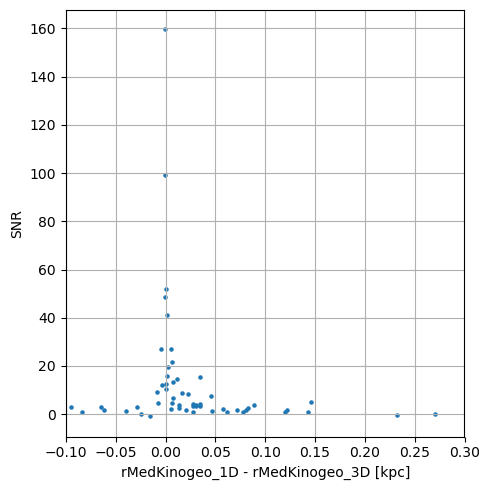

In [19]:
# plot differences of median of 1D vs 3D sampling vs. signal-to-noise ratio 
# rMedKinogeo_1D: median of distance estimation from this notebook (1D distance estimation)
# rMedKinogeo_3D: median of distance estimation from comparison data (3D distance estimation)
# SNR: signal-to-noise ratio

# _res indicates the results from this notebook (1D), _comp indicates comparison data (3D)

fig,ax = plt.subplots(figsize=(5,5))



w = np.array(r['parallax'])
parallax_error = np.array(r['parallax_error'])
astrometric_params_solved = np.array(r['astrometric_params_solved'])
phot_g_mean_mag = np.array(r['phot_g_mean_mag'])
nu_eff_used_in_astrometry = np.array(r['nu_eff_used_in_astrometry'])
pseudocolour = np.array(r['pseudocolour'])
ecl_lat = np.array(r['ecl_lat'])

# zeropoint correction

wzp = np.zeros(len(w))

for i in range(len(w)): 

    if astrometric_params_solved[i] == 31 or astrometric_params_solved[i] == 95:    
        if  phot_g_mean_mag[i] == np.nan:
            wzp[i] = -0.017                    
        else:
            wzp[i] = zpt.get_zpt(phot_g_mean_mag[i], nu_eff_used_in_astrometry[i], pseudocolour[i], ecl_lat[i], astrometric_params_solved[i])             
    else: 
        wzp[i] = 0
    
parallax = w - wzp
    
SNR = parallax/parallax_error


# rMedKinogeo

ax.grid()
ax.set_ylabel('SNR')
ax.set_xlabel('rMedKinogeo_1D - rMedKinogeo_3D [kpc]')
#ax.set_aspect('equal')
ax.scatter(results[:,4]-comp_data[:,4]/1e3,SNR,s=5)
ax.set_xlim(-0.1,0.3)
plt.tight_layout()

Comparison plots of the results of the 3D (_comp) vs 1D (_res) geometric distance sampling for all sources: 

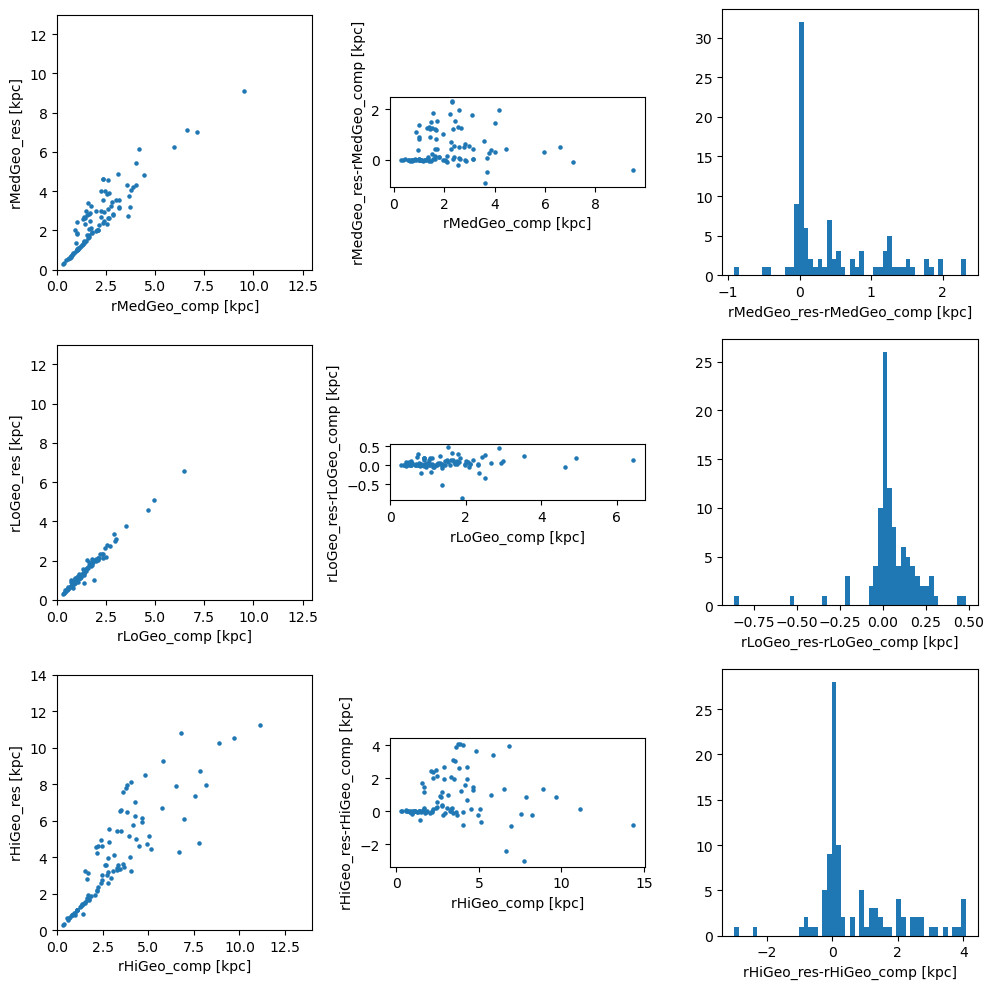

In [20]:
# plot comparison plots of Geo distance estimation
# _res indicates the results from this notebook, _comp indicates comparison data 

# plots

fig,ax = plt.subplots(3,3,figsize=(10,10))

# rMedGeo

ax[0,0].scatter(comp_data[:,1]/1e3, results[:,1],s=5)
ax[0,0].set_ylabel('rMedGeo_res [kpc]')
ax[0,0].set_xlabel('rMedGeo_comp [kpc]')
ax[0,0].set_aspect('equal')
ax[0,0].set_ylim(0,13)
ax[0,0].set_xlim(0,13)

ax[0,1].scatter(comp_data[:,1]/1e3, results[:,1]-comp_data[:,1]/1e3,s=5)
ax[0,1].set_ylabel('rMedGeo_res-rMedGeo_comp [kpc]')
ax[0,1].set_xlabel('rMedGeo_comp [kpc]')
ax[0,1].set_aspect('equal')

ax[0,2].hist(results[:,1]-comp_data[:,1]/1e3,bins=50)
ax[0,2].set_xlabel('rMedGeo_res-rMedGeo_comp [kpc]')



#rLoKinogeo

ax[1,0].scatter(comp_data[:,2]/1e3 ,results[:,2],s=5)
ax[1,0].set_ylabel('rLoGeo_res [kpc]')
ax[1,0].set_xlabel('rLoGeo_comp [kpc]')
ax[1,0].set_aspect('equal')
ax[1,0].set_ylim(0,13)
ax[1,0].set_xlim(0,13)

ax[1,1].scatter(comp_data[:,2]/1e3, results[:,2]-comp_data[:,2]/1e3,s=5)
ax[1,1].set_ylabel('rLoGeo_res-rLoGeo_comp [kpc]')
ax[1,1].set_xlabel('rLoGeo_comp [kpc]')
ax[1,1].set_aspect('equal')

ax[1,2].hist(results[:,2]-comp_data[:,2]/1e3,bins=50)
ax[1,2].set_xlabel('rLoGeo_res-rLoGeo_comp [kpc]')



#rHiKinogeo

ax[2,0].scatter(comp_data[:,3]/1e3, results[:,3],s=5)
ax[2,0].set_ylabel('rHiGeo_res [kpc]')
ax[2,0].set_xlabel('rHiGeo_comp [kpc]')
ax[2,0].set_aspect('equal')
ax[2,0].set_ylim(0,14)
ax[2,0].set_xlim(0,14)

ax[2,1].scatter(comp_data[:,3]/1e3, results[:,3]-comp_data[:,3]/1e3,s=5)
ax[2,1].set_ylabel('rHiGeo_res-rHiGeo_comp [kpc]')
ax[2,1].set_xlabel('rHiGeo_comp [kpc]')
ax[2,1].set_aspect('equal')

ax[2,2].hist(results[:,3]-comp_data[:,3]/1e3,bins=50)
ax[2,2].set_xlabel('rHiGeo_res-rHiGeo_comp [kpc]')


plt.tight_layout()

Comparison plots of the results of the 3D (_comp) vs 2D (_res) velocity sampling for all sources:

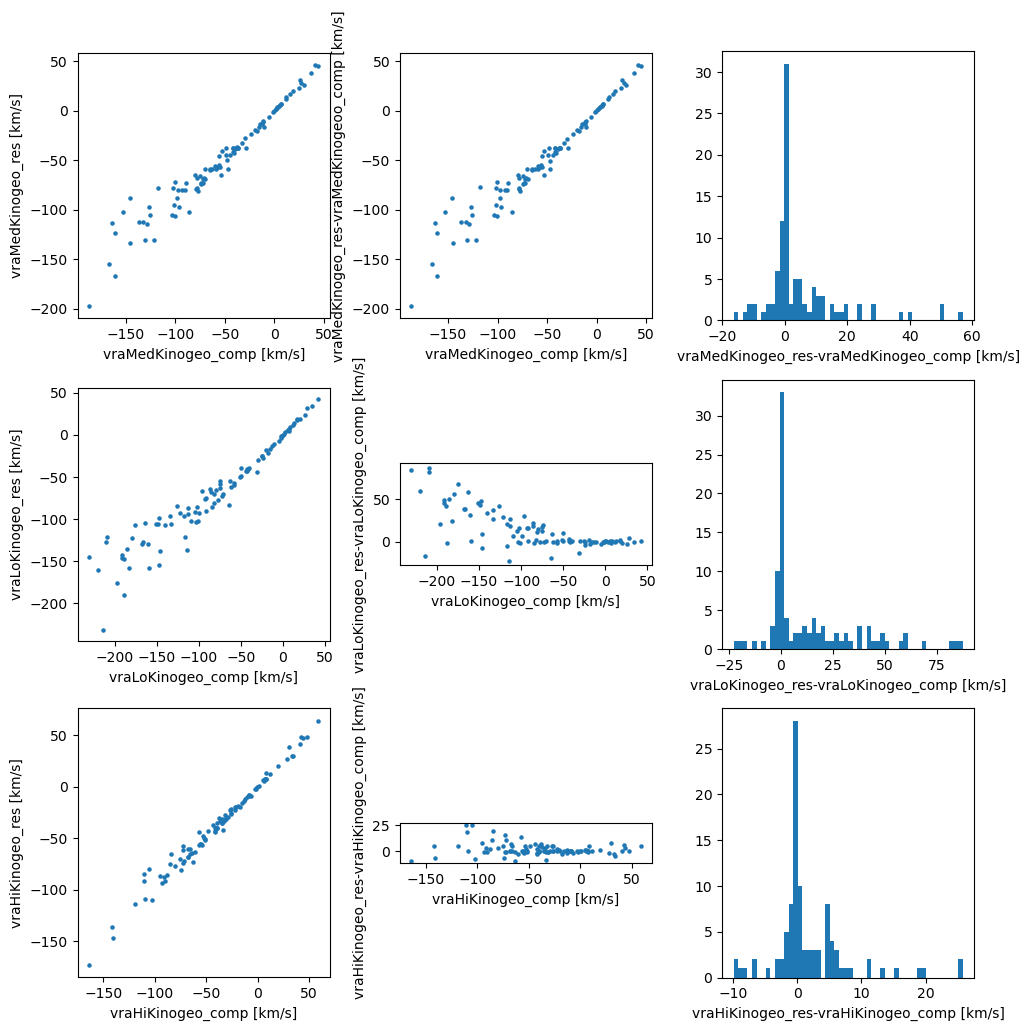

In [21]:
# comparison plots for velocity estimation (ra)

fig,ax = plt.subplots(3,3,figsize=(10,10))

# plot  comparison, _res indicates the results from this notebook, _comp indicates comparison data 

# vraMedKinogeo

ax[0,0].scatter(comp_data[:,7], results[:,7],s=5)
ax[0,0].set_ylabel('vraMedKinogeo_res [km/s]')
ax[0,0].set_xlabel('vraMedKinogeo_comp [km/s]')
ax[0,0].set_aspect('equal')

ax[0,1].scatter(comp_data[:,7], results[:,7]-comp_data[:,7]/1e3,s=5)
ax[0,1].set_ylabel('vraMedKinogeo_res-vraMedKinogeoo_comp [km/s]')
ax[0,1].set_xlabel('vraMedKinogeo_comp [km/s]')
ax[0,1].set_aspect('equal')

ax[0,2].hist(results[:,7]-comp_data[:,7],bins=50)
ax[0,2].set_xlabel('vraMedKinogeo_res-vraMedKinogeo_comp [km/s]')



# vraLoKinogeo

ax[1,0].scatter(comp_data[:,8],results[:,8],s=5)
ax[1,0].set_ylabel('vraLoKinogeo_res [km/s]')
ax[1,0].set_xlabel('vraLoKinogeo_comp [km/s]')
ax[1,0].set_aspect('equal')

ax[1,1].scatter(comp_data[:,8], results[:,8]-comp_data[:,8],s=5)
ax[1,1].set_ylabel('vraLoKinogeo_res-vraLoKinogeo_comp [km/s]')
ax[1,1].set_xlabel('vraLoKinogeo_comp [km/s]')
ax[1,1].set_aspect('equal')

ax[1,2].hist(results[:,8]-comp_data[:,8],bins=50)
ax[1,2].set_xlabel('vraLoKinogeo_res-vraLoKinogeo_comp [km/s]')



# vraHiKinogeo

ax[2,0].scatter(comp_data[:,9], results[:,9],s=5)
ax[2,0].set_ylabel('vraHiKinogeo_res [km/s]')
ax[2,0].set_xlabel('vraHiKinogeo_comp [km/s]')
ax[2,0].set_aspect('equal')

ax[2,1].scatter(comp_data[:,9], results[:,9]-comp_data[:,9],s=5)
ax[2,1].set_ylabel('vraHiKinogeo_res-vraHiKinogeo_comp [km/s]')
ax[2,1].set_xlabel('vraHiKinogeo_comp [km/s]')
ax[2,1].set_aspect('equal')

ax[2,2].hist(results[:,9]-comp_data[:,9],bins=50)
ax[2,2].set_xlabel('vraHiKinogeo_res-vraHiKinogeo_comp [km/s]')


plt.tight_layout()

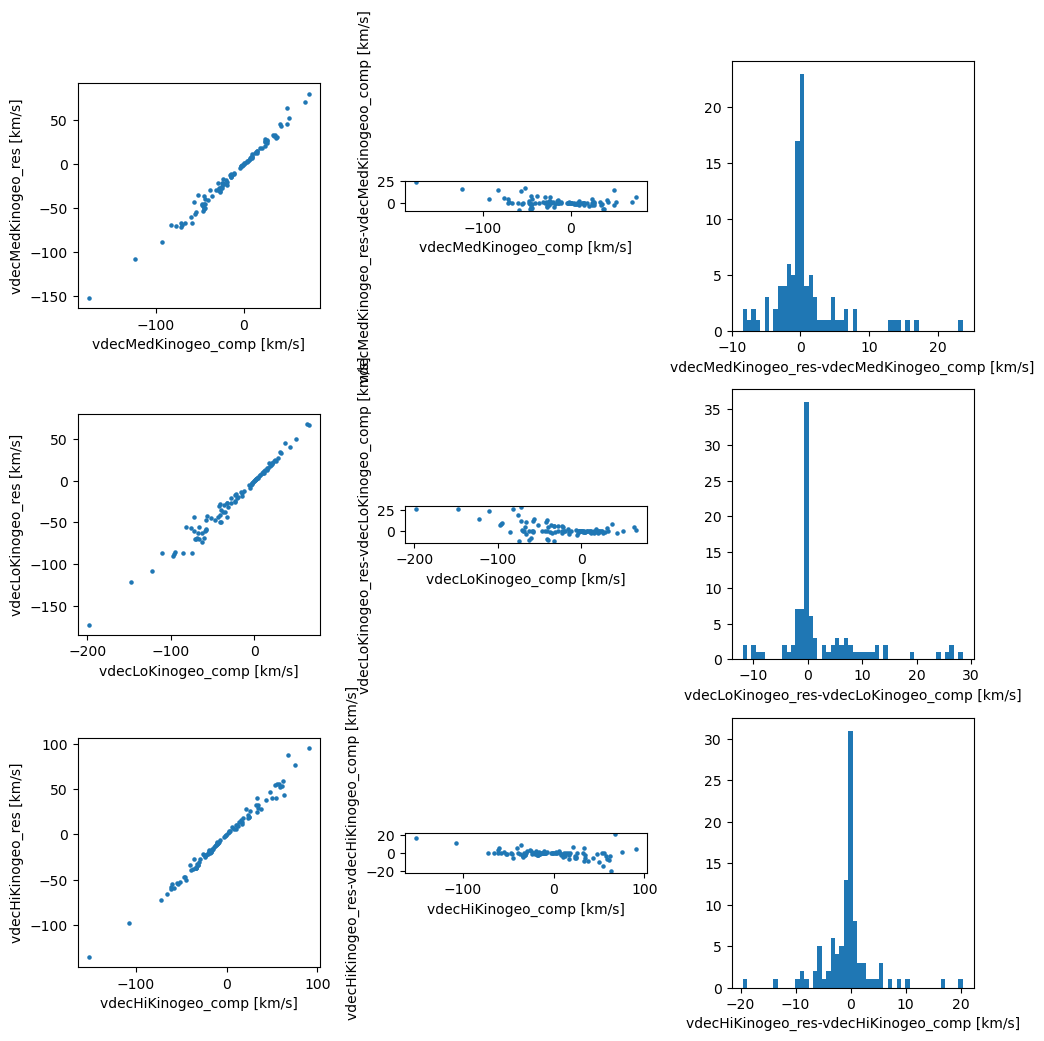

In [22]:
# comparison plots for velocity estimation (dec)

fig,ax = plt.subplots(3,3,figsize=(10,10))

# plot  comparison, _res indicates the results from this notebook, _comp indicates comparison data 

# vdecMedKinogeo

ax[0,0].scatter(comp_data[:,10], results[:,10],s=5)
ax[0,0].set_ylabel('vdecMedKinogeo_res [km/s]')
ax[0,0].set_xlabel('vdecMedKinogeo_comp [km/s]')
ax[0,0].set_aspect('equal')

ax[0,1].scatter(comp_data[:,10], results[:,10]-comp_data[:,10],s=5)
ax[0,1].set_ylabel('vdecMedKinogeo_res-vdecMedKinogeoo_comp [km/s]')
ax[0,1].set_xlabel('vdecMedKinogeo_comp [km/s]')
ax[0,1].set_aspect('equal')

ax[0,2].hist(results[:,10]-comp_data[:,10],bins=50)
ax[0,2].set_xlabel('vdecMedKinogeo_res-vdecMedKinogeo_comp [km/s]')



# vraLoKinogeo

ax[1,0].scatter(comp_data[:,11],results[:,11],s=5)
ax[1,0].set_ylabel('vdecLoKinogeo_res [km/s]')
ax[1,0].set_xlabel('vdecLoKinogeo_comp [km/s]')
ax[1,0].set_aspect('equal')

ax[1,1].scatter(comp_data[:,11], results[:,11]-comp_data[:,11],s=5)
ax[1,1].set_ylabel('vdecLoKinogeo_res-vdecLoKinogeo_comp [km/s]')
ax[1,1].set_xlabel('vdecLoKinogeo_comp [km/s]')
ax[1,1].set_aspect('equal')

ax[1,2].hist(results[:,11]-comp_data[:,11],bins=50)
ax[1,2].set_xlabel('vdecLoKinogeo_res-vdecLoKinogeo_comp [km/s]')



# vraHiKinogeo

ax[2,0].scatter(comp_data[:,12], results[:,12],s=5)
ax[2,0].set_ylabel('vdecHiKinogeo_res [km/s]')
ax[2,0].set_xlabel('vdecHiKinogeo_comp [km/s]')
ax[2,0].set_aspect('equal')

ax[2,1].scatter(comp_data[:,12], results[:,12]-comp_data[:,12],s=5)
ax[2,1].set_ylabel('vdecHiKinogeo_res-vdecHiKinogeo_comp [km/s]')
ax[2,1].set_xlabel('vdecHiKinogeo_comp [km/s]')
ax[2,1].set_aspect('equal')

ax[2,2].hist(results[:,12]-comp_data[:,12],bins=50)
ax[2,2].set_xlabel('vdecHiKinogeo_res-vdecHiKinogeo_comp [km/s]')


plt.tight_layout()

Plot of differences in medians of 1D and 3D distance vs. differences in medians of 1D and 3D ra velocities:

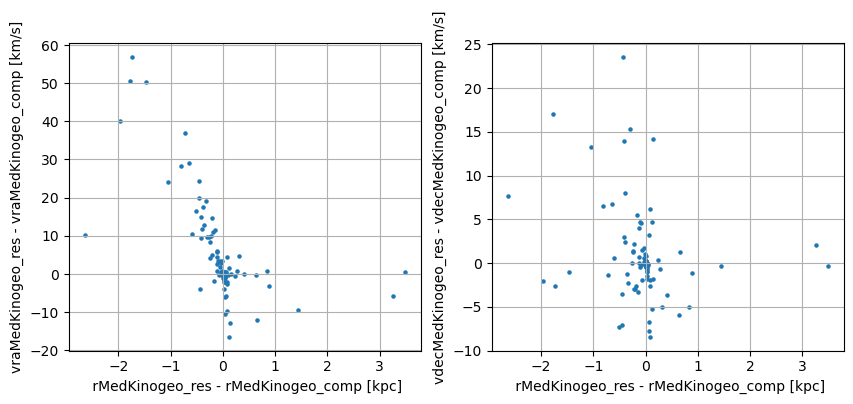

In [23]:
# plot differences in medians of 1D and 3D distance vs. differences in medians of 1D and 3D ra velocities
# 1D: _res
# 3D: _comp

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(results[:,4]-comp_data[:,4]/1e3, results[:,7]- comp_data[:,7],s=5) 

ax[0].set_ylabel('vraMedKinogeo_res - vraMedKinogeo_comp [km/s]')
ax[0].set_xlabel(' rMedKinogeo_res - rMedKinogeo_comp [kpc]')
ax[0].grid()

ax[1].scatter(results[:,4]-comp_data[:,4]/1e3, results[:,10]-comp_data[:,10] ,s=5) 

ax[1].set_ylabel('vdecMedKinogeo_res - vdecMedKinogeo_comp [km/s]')
ax[1].set_xlabel(' rMedKinogeo_res - rMedKinogeo_comp [kpc]')
ax[1].grid()

### 3.2 Compare distance samples of 10 stars of hp 6200

Now, a new file is read in containing only ten sources, for which the distance samples are available besides the summary statistics. For these, the 1D and 3D distance samples are plotted side by side to compare the sampling. 

In [35]:
# Read in comparison data:

# array containing source_ids 
id_distvel_6200_10 = np.genfromtxt("./2024-04-16/distvel_files/distvel_6200.csv", delimiter=',', skip_header=1,  dtype='int64', usecols=0)[:10]
# array containig all data (dont use source_id from this, because its rounded, instead use array above)
data_distvel_6200_10 =  np.genfromtxt('./2024-04-16/distvel_files/distvel_6200.csv', delimiter=',', skip_header=1,  dtype='float64')[:10]

# remove all rows containing nan: 
comp_data_10 = data_distvel_6200_10[~np.isnan(data_distvel_6200_10).any(axis=1), :]
comp_source_ids_10 = id_distvel_6200_10[~np.isnan(data_distvel_6200_10).any(axis=1)]

#extract data from Gaia 

source_ids_string_10 = ", ".join(map(str, comp_source_ids_10))
job_10 = Gaia.launch_job("select "
                                            "source_id, parallax, parallax_error,phot_g_mean_mag,\
                                            nu_eff_used_in_astrometry, pseudocolour,\
                                            ecl_lat, astrometric_params_solved,bp_rp,\
                                            pmra,pmra_error,pmdec, pmdec_error,parallax_pmra_corr,\
                                            parallax_pmdec_corr,pmra_pmdec_corr "
                                            "from gaiadr3.gaia_source "
                                            "where source_id in ({})".format(source_ids_string_10))
r_10 = job_10.get_results()



In [36]:
# sample posterior for each source 

rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)

rSamples_kinegeo_10 = []
rSamples_geo_10 = []

Nsamp= 1000
Nburnin= 500
    
for i in range(len(comp_source_ids_10)): 

    w = float(r_10['parallax'][i])
    sd_w = float(r_10['parallax_error'][i])   
    
    mu_ra = float(r_10['pmra'][i])
    mu_dec = float(r_10['pmdec'][i])
    sd_mu_ra = float(r_10['pmra_error'][i])
    sd_mu_dec = float(r_10['pmdec_error'][i])
    corr_w_mu_ra = float(r_10['parallax_pmra_corr'][i])
    corr_w_mu_dec = float(r_10['parallax_pmdec_corr'][i])
    corr_mu_ra_dec = float(r_10['pmra_pmdec_corr'][i])
    
    phot_g_mean_mag = float(r_10['phot_g_mean_mag'][i])
    nu_eff_used_in_astrometry = float(r_10['nu_eff_used_in_astrometry'][i])
    pseudocolour = float(r_10['pseudocolour'][i])
    ecl_lat = float(r_10['ecl_lat'][i])
    astrometric_params_solved = float(r_10['astrometric_params_solved'][i])
    
    
    source_id = int(r_10['SOURCE_ID'][i])
    print(source_id)
    healpix = math.floor(source_id / (2**(35)*4**(12-5)) )
    
    # zeropoint correction
    if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
        if  phot_g_mean_mag == np.nan:
            wzp = -0.017                    
        else:
             wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
    else: 
        wzp = 0
    
    parallax = w - wzp
    parallaxVar = sd_w**2
    propm = np.array([mu_ra,mu_dec])
    
    Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                     [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                     [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])
    
    
    Sigma_w_w = Cov3[0,0]
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_mu = np.transpose(Sigma_mu_w) #np.array([Cov3[0,1],Cov3[0,2]])
    Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                           [Cov3[2,1],Cov3[2,2]]])
    
    
    
    Cov2 = Sigma_mu_mu - np.outer(Sigma_mu_w, Sigma_w_w**(-1)*Sigma_w_mu)
    
    
    alpha = float(rows_prior_summary[healpix][6])
    beta = float(rows_prior_summary[healpix][7])
    rlen = float(rows_prior_summary[healpix][5])
    rlen_EDSD = float(rows_prior_summary[healpix][10])
    
    rInit = float(mode_post3(w=1e-3*parallax,wsd=1e-3*sd_w,rlen = rlen_EDSD,retall = False))*1e-3 
    rStep = 0.75*rInit*min(1/3, abs(sd_w/parallax))
    
    # using metrop.py------------------------------------------------------------------------------------------------------------------------------
    
    #kinegeometric samples
    samp_kinegeo = metrop(func=logkinegeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2, seed=seed,\
                          parallax=parallax, parallaxVar = parallaxVar,propm=propm, Cov3=Cov3, Cov2=Cov2, healpix=healpix, alpha=alpha,beta=beta,rlen=rlen,kfac=kfac)
    
    rSamp_kinegeo = samp_kinegeo[:,1]
    
    
    #geometric samples
    samp_geo = metrop(func=loggeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,seed=seed,\
                      parallax=parallax, parallaxVar = parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
    
    rSamp_geo = samp_geo[:,1]
    
    
    rSamples_kinegeo_10.append(rSamp_kinegeo)
    rSamples_geo_10.append(rSamp_geo)
    
# save to csv file; all samples for one source_id are in one row, same order as input 

np.savetxt('./results/rSamples_kinegeo_10.csv', rSamples_kinegeo_10, delimiter=",")
np.savetxt('./results/rSamples_geo_10.csv', rSamples_geo_10, delimiter=",")

/tmp/ipykernel_5316/4287738644.py:26: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r_10['pseudocolour'][i])


3490289711213205632


/tmp/ipykernel_5316/857391877.py:99: RuntimeWarning: invalid value encountered in log10
  return np.log10(kfac*dist) + logN
/tmp/ipykernel_5316/857391877.py:31: RuntimeWarning: invalid value encountered in log
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
/tmp/ipykernel_5316/857391877.py:31: RuntimeWarning: invalid value encountered in power
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha


3490289715508854016
3490289749867760896


/tmp/ipykernel_5316/4287738644.py:25: UserWarning: Warning: converting a masked element to nan.
  nu_eff_used_in_astrometry = float(r_10['nu_eff_used_in_astrometry'][i])


3490289814292421888
3490289818586888576


/Home/no233/linux/.local/lib/python3.9/site-packages/zero_point/zpt.py:233: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  warnings.warn(


3490289852947807744
3490289883011898496
3490289887307937920
3490289921667284352
3490289956027023232
3490290054810590720
3490290089170329984
3490290089170330240
3490290089170331008
3490290093465144320
3490290093465144448
3490290123530068992
3490290157889807232
3490290157889807616
3490290157889809024
3490290162184620928
3490290226609285888
3490290230904930560
3490290299624407424
3490290398407978752
3490290471422342144
3490290471423100160
3490290505782080128
3490290574502314752
3490290604566409472
3490290608862052864
3490290638926148096
3490290638926148864
3490290711941269248
3490290746301007488
3490290776365105024
3490290776365105792
3490290776365106048
3490290849380220544
3490290879444313856
3490290879444314496
3490290913804053376
3490290948163792000
3490290952459436032
3490290986819174528
3490291051243010304
3490291055538651776
3490291119962484736
3490291188681962368
3490291188681962496
3490291192977982080
3490291223041700992
3490291223041701632
3490291261696248576
3490291261697127040


In [37]:
# plot samples

from matplotlib.backends.backend_pdf import PdfPages

# load saved 2D samples
rSamples_kinegeo_10 = np.loadtxt('./results/rSamples_kinegeo_10.csv', delimiter=',') 

rMedKinegeo_10_all = []
rLoKinegeo_10_all = []
rHiKinegeo_10_all = []

p = PdfPages('./results/results_10.pdf')

for i in range(len(comp_source_ids_10)):
    
    # Create a new figure for each iteration
    
    fig,ax = plt.subplots(2,2,figsize=(7,7), gridspec_kw={'height_ratios': [1,2]})
    
    ax[0,0].plot(np.arange(0,len(rSamples_kinegeo_10[i]),1),rSamples_kinegeo_10[i])
    ax[1,0].hist(rSamples_kinegeo_10[i],bins=20,density=True)
    plt.suptitle(f"Gaia DR3 {comp_source_ids_10[i]}")
    ax[1,0].set_title(f"2D sampling")
    plt.tight_layout()
    
    rQuantKinegeo = np.quantile(rSamples_kinegeo_10[i],probs)
    
    rMedKinegeo = rQuantKinegeo[0]
    rLoKinegeo = rQuantKinegeo[1]
    rHiKinegeo= rQuantKinegeo[2]
    
    rMedKinegeo_10_all.append(rMedKinegeo)
    rLoKinegeo_10_all.append(rLoKinegeo)
    rHiKinegeo_10_all.append(rHiKinegeo)
    
    ax[1,0].axvline(rMedKinegeo,color='black') 
    ax[1,0].axvline(rLoKinegeo,linestyle='--',color = 'black') 
    ax[1,0].axvline(rHiKinegeo,linestyle='--',color = 'black') 
    
    
    # load compasion samples 
    
    j = np.where(comp_source_ids_10 == comp_source_ids_10[i])[0][0]
    
    comp_samples_kinegeo_10 = np.loadtxt(f'./2024-04-16/posterior_samples/kinogeosamples_6200_{comp_source_ids_10[i]}.csv', delimiter=',',skiprows=1)
    comp_rSamp_kinegeo_10 = comp_samples_kinegeo_10[:,0]
    
    ax[0,1].plot(np.arange(0,len(comp_rSamp_kinegeo_10),1),comp_rSamp_kinegeo_10/1e3)
    ax[1,1].hist(comp_rSamp_kinegeo_10/1e3,bins=20,density=True)
    ax[1,1].set_title(f"3D sampling")
    
    ax[1,1].axvline(comp_data_10[j][4]/1e3 ,color='black') 
    ax[1,1].axvline(comp_data_10[j][5]/1e3, linestyle='--',color = 'black') 
    ax[1,1].axvline(comp_data_10[j][6]/1e3,linestyle='--',color = 'black') 
    
    
    ax[1,0].sharex(ax[1,1])
    p.savefig()
    plt.close()

rMedKinegeo_10_all = np.array(rMedKinegeo_10_all)
rLoKinegeo_10_all = np.array(rLoKinegeo_10_all)
rHiKinegeo_10_all = np.array(rHiKinegeo_10_all)

p.close()

For those samples, the summary statictics of the kinegeometric distance estimation are compared with the same comparison plots as before. 

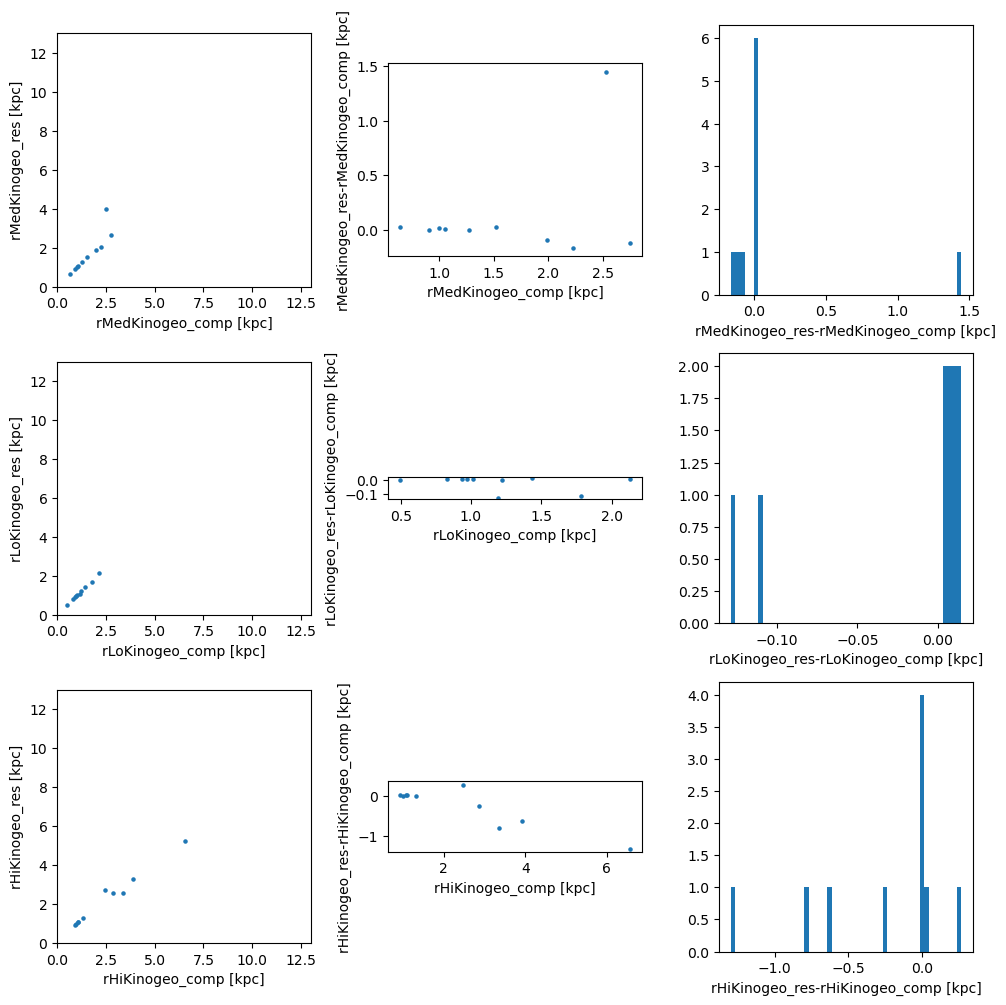

In [27]:
fig,ax = plt.subplots(3,3,figsize=(10,10))

# plot  comparison, _res indicates the results from this notebook, _comp indicates comparison data 

# rMedKinogeo

ax[0,0].scatter(comp_data_10[:,4]/1e3, rMedKinegeo_10_all,s=5)
ax[0,0].set_ylabel('rMedKinogeo_res [kpc]')
ax[0,0].set_xlabel('rMedKinogeo_comp [kpc]')
ax[0,0].set_aspect('equal')
ax[0,0].set_ylim(0,13)
ax[0,0].set_xlim(0,13)

ax[0,1].scatter(comp_data_10[:,4]/1e3, rMedKinegeo_10_all-comp_data_10[:,4]/1e3,s=5)
ax[0,1].set_ylabel('rMedKinogeo_res-rMedKinogeo_comp [kpc]')
ax[0,1].set_xlabel('rMedKinogeo_comp [kpc]')
ax[0,1].set_aspect('equal')

ax[0,2].hist(rMedKinegeo_10_all-comp_data_10[:,4]/1e3,bins=50)
ax[0,2].set_xlabel('rMedKinogeo_res-rMedKinogeo_comp [kpc]')


#rLoKinogeo

ax[1,0].scatter(comp_data_10[:,5]/1e3 ,rLoKinegeo_10_all,s=5)
ax[1,0].set_ylabel('rLoKinogeo_res [kpc]')
ax[1,0].set_xlabel('rLoKinogeo_comp [kpc]')
ax[1,0].set_aspect('equal')
ax[1,0].set_ylim(0,13)
ax[1,0].set_xlim(0,13)

ax[1,1].scatter(comp_data_10[:,5]/1e3, rLoKinegeo_10_all-comp_data_10[:,5]/1e3,s=5)
ax[1,1].set_ylabel('rLoKinogeo_res-rLoKinogeo_comp [kpc]')
ax[1,1].set_xlabel('rLoKinogeo_comp [kpc]')
ax[1,1].set_aspect('equal')

ax[1,2].hist(rLoKinegeo_10_all-comp_data_10[:,5]/1e3,bins=50)
ax[1,2].set_xlabel('rLoKinogeo_res-rLoKinogeo_comp [kpc]')



#rHiKinogeo

ax[2,0].scatter(comp_data_10[:,6]/1e3, rHiKinegeo_10_all,s=5)
ax[2,0].set_ylabel('rHiKinogeo_res [kpc]')
ax[2,0].set_xlabel('rHiKinogeo_comp [kpc]')
ax[2,0].set_aspect('equal')
ax[2,0].set_ylim(0,13)
ax[2,0].set_xlim(0,13)

ax[2,1].scatter(comp_data_10[:,6]/1e3, rHiKinegeo_10_all-comp_data_10[:,6]/1e3,s=5)
ax[2,1].set_ylabel('rHiKinogeo_res-rHiKinogeo_comp [kpc]')
ax[2,1].set_xlabel('rHiKinogeo_comp [kpc]')
ax[2,1].set_aspect('equal')

ax[2,2].hist(rHiKinegeo_10_all-comp_data_10[:,6]/1e3,bins=50)
ax[2,2].set_xlabel('rHiKinogeo_res-rHiKinogeo_comp [kpc]')


plt.tight_layout()

### 3.3 comparison of samples for a single source_id

To compare the samples of sources which have 1D and 3D results that deviate a lot from each other, the sample comparison is plotted with the option to enter the source_id of interest. Make sure that 3D samples of that source_id are available under the path "./results_est_distvel/posterior_samples/kinogeosamples_6200_{source_id}.csv " and that the source_id is included in the file containing the 3D summary statistics: "./results_est_distvel/distvel_files/distvel_6200_new.csv". 

/tmp/ipykernel_5316/2811096673.py:42: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r['pseudocolour'])


3490289749867760896


/tmp/ipykernel_5316/857391877.py:99: RuntimeWarning: invalid value encountered in log10
  return np.log10(kfac*dist) + logN
/tmp/ipykernel_5316/857391877.py:31: RuntimeWarning: invalid value encountered in log
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
/tmp/ipykernel_5316/857391877.py:31: RuntimeWarning: invalid value encountered in power
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha


Data for Gaia DR3 3490289749867760896: 

HEALpixel level 5: 6200
parallax [mas]:  0.9456172699741828
parallax error [mas]:  0.9242838621139526
SNR parallax/parallax_error:  1.0230810130249792
Zeropoint [mas] -0.012552
Zeropointcorrected parallax w[mas]:  0.9581692699741828
proper motion ra [mas/yr]: -2.5227925377013465
proper motion dec [mas/yr]: -0.4972104607767501
proper motion ra error [mas/yr]: 0.970378577709198
proper motion dec error [mas/yr]: 0.6900551319122314
parallax - proper motion ra correlation:  -0.1622094213962555
parallax - proper motion dec correlation:  -0.14073950052261353
proper motion ra-dec correlation:  -0.0007732694502919912


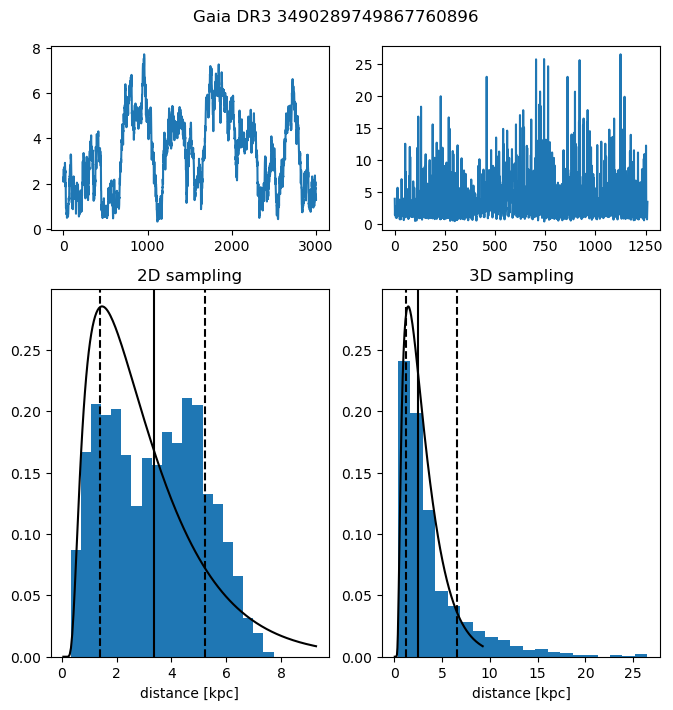

In [32]:
rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)
Nsamp= 3000
Nburnin= 100
probs = np.array([0.5,0.1586553, 0.8413447])


# array containing source_ids 
id_distvel_6200 = np.genfromtxt("./2024-04-16/distvel_files/distvel_6200.csv", delimiter=',', skip_header=1,  dtype='int64', usecols=0)
# array containig all data (dont use source_id from this, because its rounded, instead use array above)
data_distvel_6200 =  np.genfromtxt('./2024-04-16/distvel_files/distvel_6200.csv', delimiter=',', skip_header=1,  dtype='float64')

# remove all rows containing nan: 
comp_data = data_distvel_6200[~np.isnan(data_distvel_6200).any(axis=1), :]
comp_source_ids = id_distvel_6200[~np.isnan(data_distvel_6200).any(axis=1)]


source_id = 3490289749867760896 #3490292120690543616

job = Gaia.launch_job("select "
                                            "source_id, parallax, parallax_error,phot_g_mean_mag,\
                                            nu_eff_used_in_astrometry, pseudocolour,\
                                            ecl_lat, astrometric_params_solved,bp_rp,\
                                            pmra,pmra_error,pmdec, pmdec_error,parallax_pmra_corr,\
                                            parallax_pmdec_corr,pmra_pmdec_corr "
                                            "from gaiadr3.gaia_source "
                                            "where source_id in ({})".format(source_id))
r = job.get_results()

w = float(r['parallax'])
sd_w = float(r['parallax_error'])   

mu_ra = float(r['pmra'])
mu_dec = float(r['pmdec'])
sd_mu_ra = float(r['pmra_error'])
sd_mu_dec = float(r['pmdec_error'])
corr_w_mu_ra = float(r['parallax_pmra_corr'])
corr_w_mu_dec = float(r['parallax_pmdec_corr'])
corr_mu_ra_dec = float(r['pmra_pmdec_corr'])

phot_g_mean_mag = float(r['phot_g_mean_mag'])
nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'])
pseudocolour = float(r['pseudocolour'])
ecl_lat = float(r['ecl_lat'])
astrometric_params_solved = float(r['astrometric_params_solved'])


#source_id = int(r['source_id'])
print(source_id)
healpix = math.floor(source_id / (2**(35)*4**(12-5)) )

# zeropoint correction
if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
    if  phot_g_mean_mag == np.nan:
        wzp = -0.017                    
    else:
         wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
else: 
    wzp = 0

parallax = w - wzp
parallaxVar = sd_w**2
propm = np.array([mu_ra,mu_dec])

Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                 [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                 [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])


Sigma_w_w = Cov3[0,0]
Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
Sigma_w_mu = np.transpose(Sigma_mu_w) #np.array([Cov3[0,1],Cov3[0,2]])
Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                       [Cov3[2,1],Cov3[2,2]]])



Cov2 = Sigma_mu_mu - np.outer(Sigma_mu_w, Sigma_w_w**(-1)*Sigma_w_mu)


alpha = float(rows_prior_summary[healpix][6])
beta = float(rows_prior_summary[healpix][7])
rlen = float(rows_prior_summary[healpix][5])
rlen_EDSD = float(rows_prior_summary[healpix][10])

rInit = float(mode_post3(w=1e-3*parallax,wsd=1e-3*sd_w,rlen = rlen_EDSD,retall = False))*1e-3 
rStep = 0.75*rInit*min(1/3, abs(sd_w/parallax))

# using metrop.py------------------------------------------------------------------------------------------------------------------------------

#kinegeometric samples
samp_kinegeo = metrop(func=logkinegeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2, seed=seed,\
                      parallax=parallax, parallaxVar = parallaxVar,propm=propm, Cov3=Cov3, Cov2=Cov2, healpix=healpix, alpha=alpha,beta=beta,rlen=rlen,kfac=kfac)

rSamp_kinegeo = samp_kinegeo[:,1]


#geometric samples
samp_geo = metrop(func=loggeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,seed=seed,\
                  parallax=parallax, parallaxVar = parallaxVar,alpha=alpha,beta=beta,rlen=rlen)

rSamp_geo = samp_geo[:,1]

fig,ax = plt.subplots(2,2,figsize=(7,7), gridspec_kw={'height_ratios': [1,2]})

ax[0,0].plot(np.arange(0,len(rSamp_kinegeo),1),rSamp_kinegeo)

ax[1,0].hist(rSamp_kinegeo,bins=20,density=True)
plt.suptitle(f"Gaia DR3 {source_id}")
ax[1,0].set_title(f"2D sampling")
plt.tight_layout()

rQuantKinegeo = np.quantile(rSamp_kinegeo,probs)

rMedKinegeo = rQuantKinegeo[0]
rLoKinegeo = rQuantKinegeo[1]
rHiKinegeo= rQuantKinegeo[2]

ax[1,0].axvline(rMedKinegeo,color='black') 
ax[1,0].axvline(rLoKinegeo,linestyle='--',color = 'black') 
ax[1,0].axvline(rHiKinegeo,linestyle='--',color = 'black') 

# load compasion samples 

j = np.where(comp_source_ids == source_id)[0][0]

comp_samples_kinegeo = np.loadtxt(f'./2024-04-16/posterior_samples/kinogeosamples_6200_{source_id}.csv', delimiter=',',skiprows=1)

comp_rSamp_kinegeo= comp_samples_kinegeo[:,0]

ax[0,1].plot(np.arange(0,len(comp_rSamp_kinegeo),1),comp_rSamp_kinegeo/1e3)

ax[1,1].hist(comp_rSamp_kinegeo/1e3,bins=20,density=True)
ax[1,1].set_title(f"3D sampling")

ax[1,1].axvline(comp_data[j][4]/1e3 ,color='black') 
ax[1,1].axvline(comp_data[j][5]/1e3, linestyle='--',color = 'black') 
ax[1,1].axvline(comp_data[j][6]/1e3,linestyle='--',color = 'black') 

# distance range for plotting
rplotlo = 0.2*min(rSamp_kinegeo)
rplothi = 1.2*max(rSamp_kinegeo)

r_plot = np.linspace(rplotlo,rplothi,200)

# plot kinegeo + geo posterior   

logKinegeo_plot=[]

for i in r_plot: 
    logKinegeo_plot.append(logkinegeopostdensity(i, parallax, parallaxVar ,propm, Cov3, Cov2, healpix,alpha,beta,rlen, kfac))

kinegeo_plot = 10**(np.array(logKinegeo_plot))         
kinegeo_norm = integrate.trapezoid(kinegeo_plot,r_plot)


ax[1,0].plot(r_plot,kinegeo_plot/kinegeo_norm, label='kinegeometric posterior',color='k')
ax[1,1].plot(r_plot,kinegeo_plot/kinegeo_norm, label='kinegeometric posterior',color='k')

ax[1,0].set_xlabel('distance [kpc]')
ax[1,1].set_xlabel('distance [kpc]')

#ax[0].set_ylim(0,0.3)
#ax[1].set_ylim(0,0.3)

print('\033[1m' + f'Data for Gaia DR3 {source_id}: ' + '\033[0m')
print('')
print('HEALpixel level 5:',healpix)
print('parallax [mas]: ',w)
print('parallax error [mas]: ',sd_w)
print('SNR parallax/parallax_error: ', w/sd_w)
print('Zeropoint [mas]', wzp)
print('Zeropointcorrected parallax w[mas]: ',parallax)
print('proper motion ra [mas/yr]:',mu_ra)
print('proper motion dec [mas/yr]:',mu_dec)
print('proper motion ra error [mas/yr]:',sd_mu_ra)
print('proper motion dec error [mas/yr]:',sd_mu_dec)
print('parallax - proper motion ra correlation: ',corr_w_mu_ra)
print('parallax - proper motion dec correlation: ',corr_w_mu_dec)
print('proper motion ra-dec correlation: ',corr_mu_ra_dec)
